In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import raybay

In [2]:
# Load treatment plan results
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)
#res_dummy = np.load('dummy/res_linear_quadratic_dummy_minimize.pkl', allow_pickle=True)
#res_bayes = np.load('bayes/res_linear_quadratic_gp_minimize.pkl', allow_pickle=True)

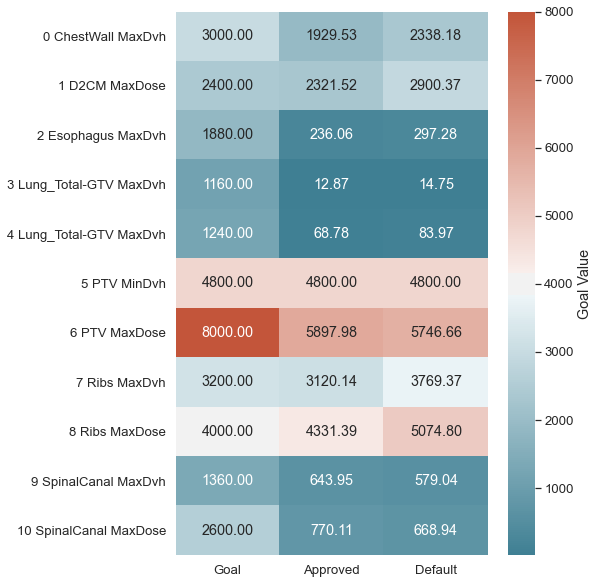

In [4]:
# Compare goal values
#idx_dummy = np.argmin(res_dummy.opt_result.func_vals)
#idx_bayes = np.argmin(res_bayes.opt_result.func_vals)
X = np.zeros((len(approved.goal_df), 3))
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
for index, row in approved.goal_df.iterrows():
    X[index, 0] = row['AcceptanceLevel']
    X[index, 1] = approved.goal_dict[index][0]
    X[index, 2] = default.goal_dict[index][0]
    #X[index, 3] = res_dummy.goal_dict[index][idx_dummy]
    #X[index, 4] = res_bayes.goal_dict[index][idx_bayes]
Y = pd.DataFrame(columns=['Goal', 'Approved', 'Default'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(7, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Goal Value'},
            fmt=".2f");